# Code for Splunk Message Processing

## File Name Entry

In [48]:
# Enter file names for each required parameter; if not in same folder, provide path

# .csv containing all s-tag messages
s_tag_messages = 'S_TagFile.csv' 
# Splunk query: index="rtr-prod" raw_ocs_message tmov | regex _raw="[A-Z]*[S][A-Z]*[01]\d{3}"

# .csv containing all NEW TSCH messages for the O, R, and B lines
tsch_messages = 'TSCH_Messages.csv' 
# Splunk query: index = "rtr-prod" raw_ocs_message TSCH NEW (O OR R OR B)

# .csv containing all trips between the hours of 11pm and 2am the next day (same revenue day)
night_trips = 'LateNightTrips.csv'
# Splunk query: 
# index="rtr-prod" raw_ocs_message TMOV (R OR B OR O)
#| eval event_hour=strftime(_time, "%H")
#| where (event_hour >= "23" OR event_hour < "02")

# Enter a name for the output .csv (if a .csv export is required)
output_file_name = 'YourFileName.csv'


## Required Functions

In [40]:
import pandas as pd
import numpy as np
from datetime import timedelta

# Required file to calculate closest station
locations = pd.read_csv('/Users/egulotty/Documents/t-tags/locations.csv')

# Function to assign the correct revenue day to each entry
def assign_revenue_day(df):
    # Convert the 'timestamp' column to a datetime object
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

    # Define the time boundaries for a revenue day
    start_time = pd.to_datetime('05:00:00').time()
    end_time = pd.to_datetime('02:00:00').time()

    # Assign revenue days based on the timestamp
    df['revenue_day'] = df['timestamp'].apply(lambda x: x.date() if x.time() >= start_time else (x.date() - pd.DateOffset(days=1)))

    # Convert the 'revenue_day' column to the desired string format
    df['revenue_day'] = df['revenue_day'].apply(lambda x: x.strftime('%Y-%m-%d'))

    return df

# Function to find the closest location
def find_closest_location(lat, lon, locations):
    distances = np.sqrt((locations['latitude'] - lat) ** 2 + (locations['longitude'] - lon) ** 2)
    closest_index = distances.idxmin()
    return locations.loc[closest_index, 'loc_name']

# Function that finds the first & last instances of each train_UID per revenue day, along with location when tagged/untagged
def first_last_instance(df):
    # Convert the 'timestamp' column to a datetime object
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-d %H:%M:%S.%f')

    # Sort the DataFrame by 'revenue_day', 'train_UID', and 'timestamp'
    df = df.sort_values(by=['revenue_day', 'train_UID', 'timestamp'])

    # Initialize a list to store the processed data
    processed_data = []

    # Iterate through unique revenue days
    for revenue_day, day_group in df.groupby('revenue_day'):
        # Group by 'trip_UID' within the revenue day
        trip_groups = day_group.groupby('train_UID')
        
        for train_UID, trip_group in trip_groups:
            # Find the first and last instances of each train_UID within the revenue day
            first_instance = trip_group.iloc[0]  # First row
            last_instance = trip_group.iloc[-1]  # Last row
            
            # Extract the relevant data
            time_tagged = first_instance['timestamp']
            time_untagged = last_instance['timestamp']
            trip_UID = first_instance['trip_UID']
            train_id = train_UID
            line = last_instance['transit_line']
            lat = first_instance['lat']
            lon = first_instance['lon']

            # Find the closest location
            loc_name = find_closest_location(lat, lon, locations)

            # Check if time_tagged is within 5 minutes or less of time_untagged
            if (time_untagged - time_tagged) >= timedelta(minutes=5):
                # Append the data to the processed_data list
                processed_data.append([revenue_day, line, trip_UID, train_id, time_tagged, time_untagged, loc_name, lat, lon])

    # Create a DataFrame from the processed data
    result_df = pd.DataFrame(processed_data, columns=['revenue_day', 'line', 'trip_UID', 'train_id', 'time_tagged', 'time_untagged', 'loc_name', 'lat', 'lon'])

    return result_df

def determine_recorded_departure_time(recorded_df, tsch_df, locations):
    result_df = pd.DataFrame(columns=['trip_UID', 'train_UID', 'transit_line', 'lat', 'lon', 'train_id', 'revenue_day', 'recorded_departure', 'location','recorded_departure_trimmed'])

    # Iterate over unique trip_UIDs in recorded movement dataframe
    for trip_UID in recorded_df['trip_UID'].unique():
        trip_events = recorded_df[recorded_df['trip_UID'] == trip_UID].sort_values(by='timestamp')

        # Iterate over each event for the current trip_UID
        for index, event in trip_events.iterrows():
            current_time = event['timestamp']

            # Check if there is another event within 20 seconds
            next_event_candidates = trip_events[(trip_events['timestamp'] > current_time) & 
                                                 (trip_events['timestamp'] <= current_time + pd.Timedelta(seconds=20))]

            if not next_event_candidates.empty:
                next_event = next_event_candidates.iloc[0, :]

                # Calculate the closest location to the current event using lat and lon
                closest_location = find_closest_location(event['lat'], event['lon'], locations)

                # Check if the closest location contains "departure" in the 'loc_name'
                if 'departing' in closest_location.lower():
                    # Save the recorded departure time and location
                    recorded_departure_time = current_time
                    location = closest_location

                    # Convert recorded_departure_time to datetime and format as HH:MM
                    recorded_departure_trimmed = pd.to_datetime(recorded_departure_time).strftime('%H:%M')

                    temp_df = pd.DataFrame({
                        'trip_UID': [trip_UID],
                        'train_UID': [event['train_UID']],
                        'transit_line': [event['transit_line']],
                        'lat': [event['lat']],
                        'lon': [event['lon']],
                        'train_id': [event['train_id']],
                        'revenue_day': [event['revenue_day']],
                        'recorded_departure': [recorded_departure_time],
                        'recorded_departure_trimmed': [recorded_departure_trimmed],
                        #'scheduled_departure': [None],  # Placeholder for scheduled departure time
                        'location': [location]
                    })
                    result_df = pd.concat([result_df, temp_df], ignore_index=True)
                    break  # Exit the loop once a valid departure time is found
                
    # Merge with scheduled departure time from tsch dataframe
    result_df = pd.merge(result_df, tsch_df[['trip_UID', 'scheduled_departure']], on='trip_UID', how='inner')

    return result_df


# Function to combine the results of functions which calculate first and last trip, as well as recorded departure time
def process_dataframes(first_last_trip, departure_time):
    result = pd.merge(departure_time, first_last_trip[['trip_UID', 'time_tagged', 'loc_name']], on='trip_UID', how='inner')
    result['time_tagged_trimmed'] = pd.to_datetime(result['time_tagged']).dt.strftime('%H:%M')
    result['tagged_before'] = result['time_tagged'] < result['recorded_departure']
    result['time_tagged'] = pd.to_datetime(result['time_tagged'])
    result['recorded_departure'] = pd.to_datetime(result['recorded_departure'])
    result['time_difference'] = result['time_tagged'] - result['recorded_departure']
    result['time_diff'] = result['recorded_departure'] - result['time_tagged']
    result['time_difference_trimmed'] = result['time_diff'].apply(lambda x: '{:02}:{:02}'.format(int(x.total_seconds() // 60), int(x.total_seconds() % 60)))
    
    return result

## S-Tag (LTOTD) Message Breakdown

In [22]:
s_tags = pd.read_csv(s_tag_messages)
s_tags.head()

,_raw,_time,host,index,linecount,source,sourcetype,splunk_server
0,f9042057ce22 2024-01-07 02:20:53.863 [info] ra...,2024-01-07T02:20:53.863-05:00,ip-10-0-45-99.ec2.internal,rtr-prod,1,http:lambda-generic,httpevent,idx-i-029d6a0b765997b47.mbta.splunkcloud.com
1,f9042057ce22 2024-01-07 02:20:22.682 [info] ra...,2024-01-07T02:20:22.682-05:00,ip-10-0-45-99.ec2.internal,rtr-prod,1,http:lambda-generic,httpevent,idx-i-029d6a0b765997b47.mbta.splunkcloud.com
2,f9042057ce22 2024-01-07 02:20:15.673 [info] ra...,2024-01-07T02:20:15.674-05:00,ip-10-0-45-99.ec2.internal,rtr-prod,1,http:lambda-generic,httpevent,idx-i-0edc1ae1e83924d06.mbta.splunkcloud.com
3,f9042057ce22 2024-01-07 02:20:04.673 [info] ra...,2024-01-07T02:20:04.674-05:00,ip-10-0-45-99.ec2.internal,rtr-prod,1,http:lambda-generic,httpevent,idx-i-029d6a0b765997b47.mbta.splunkcloud.com
4,f9042057ce22 2024-01-07 02:19:56.721 [info] ra...,2024-01-07T02:19:56.721-05:00,ip-10-0-45-99.ec2.internal,rtr-prod,1,http:lambda-generic,httpevent,idx-i-029d6a0b765997b47.mbta.splunkcloud.com


In [23]:
s_tags['message'] = s_tags['_raw'].str.extract(r'raw_ocs_message (.*)')

# Split data based on comma divisions
split_data = s_tags['message'].str.split(',', expand=True)

# CHANGE COLUMNS AS NAMING CONVENTIONS/MESSAGES ARE UPDATED/ALTERED
columns = ['sequence', 'group_type', 'timestamp', 'transit_line', 'train_UID', 'lat', 'lon', 'train_tag',
           'direction_route', 'trip_UID', 'train_id', 'express', 'last_lat', 'last_lon']

# Assign the correct column names
split_data.columns = columns

# Convert columns to appropriate data types, handling empty entries
split_data['sequence'] = split_data['sequence'].astype(float)  # Converting to float to handle potential NaN values
split_data['lat'] = split_data['lat'].replace('', float('nan')).astype(float)
split_data['lon'] = split_data['lon'].replace('', float('nan')).astype(float)
split_data['train_tag'] = split_data['train_tag'].replace('', float('nan')).astype(float)
split_data['direction_route'] = split_data['direction_route'].replace('', float('nan')).astype(float)
#split_data['train_id'] = pd.to_numeric(split_data['train_id'], errors='coerce')
split_data['timestamp'] = s_tags['_time']
split_data['timestamp'] = pd.to_datetime(split_data['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')

s_tag_raw = split_data

# To check that dtypes were updated correctly
s_tag_raw.dtypes

# Assign revenue day
assign_revenue_day(s_tag_raw)

# Check the final dataframe
s_tag_raw.head()

,sequence,group_type,timestamp,transit_line,train_UID,lat,lon,train_tag,direction_route,trip_UID,train_id,express,last_lat,last_lon,revenue_day
0,5681.0,TMOV,2024-01-07 02:20:53.863000-05:00,R,547A50B2,42.396180,-71.140540,0.0,0.0,98110080,DS1872,,42.396008,-71.140064,2024-01-06
1,5672.0,TMOV,2024-01-07 02:20:22.682000-05:00,R,547A50B2,42.396008,-71.140064,1.0,1.0,9811007F,DS1872,,42.396201,-71.139383,2024-01-06
2,5671.0,TMOV,2024-01-07 02:20:15.674000-05:00,R,547A50B2,42.396201,-71.139383,1.0,1.0,9811007F,DS1872,,42.396346,-71.139147,2024-01-06
3,5668.0,TMOV,2024-01-07 02:20:04.674000-05:00,R,547A50B2,42.396346,-71.139147,1.0,1.0,9811007F,DS1872,,42.396417,-71.138975,2024-01-06
4,5667.0,TMOV,2024-01-07 02:19:56.721000-05:00,R,547A50B2,42.396417,-71.138975,1.0,1.0,9811007F,DS1872,,42.396381,-71.138602,2024-01-06


## TSCH Message Breakdown

In [24]:
tsch = pd.read_csv(tsch_messages)
tsch.head()

,_raw,_time,add_type,car_tags,conflict_vehicles,consist,consist_tags,counter,delete_status,dest_sta,...,timestamp,train_uid,transitline,trip_type,trip_uid,turnaround_time,type,vehicle,vehicle_id,vehicle_time
0,f9042057ce22 2024-01-07 15:12:44.401 [info] ra...,2024-01-07T15:12:44.401-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f9042057ce22 2024-01-07 15:11:26.798 [info] ra...,2024-01-07T15:11:26.799-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f9042057ce22 2024-01-07 15:06:47.306 [info] ra...,2024-01-07T15:06:47.307-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f9042057ce22 2024-01-07 14:44:37.191 [info] ra...,2024-01-07T14:44:37.191-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f9042057ce22 2024-01-07 14:32:30.563 [info] ra...,2024-01-07T14:32:30.564-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
tsch['message'] = tsch['_raw'].str.extract(r'raw_ocs_message (.*)')
t_split_data = tsch['message'].str.split(',', expand=True)
columns = ['sequence', 'group_type', 'timestamp', 'transit_line', 'message_type','trip_UID', 'add_type', 'trip_type', 'scheduled_departure', 'scheduled_arrival',
          'route', 'origin', 'destination', 'prev_trip_id', 'next_trip_id']
t_split_data.columns = columns

# Check if split worked
t_split_data.head()

,sequence,group_type,timestamp,transit_line,message_type,trip_UID,add_type,trip_type,scheduled_departure,scheduled_arrival,route,origin,destination,prev_trip_id,next_trip_id
0,44744,TSCH,15:12:44,R,NEW,9811027A,A,R,,,,CADDIGAN YARD,,0,0
1,44633,TSCH,15:11:26,R,NEW,98110279,A,L,15:11,15:18,rad,ASHMONT,CABOT YARD,0,0
2,44297,TSCH,15:06:47,R,NEW,98110278,A,R,,,,BRAINTREE,,0,0
3,42675,TSCH,14:44:37,R,NEW,98110277,A,R,,,,CADDIGAN YARD,,0,0
4,41862,TSCH,14:32:30,R,NEW,98110276,A,L,14:32,14:55,rad,BRAINTREE,CABOT YARD,0,0


## Late Night Trips (11pm~2am) Breakdown

In [26]:
late_nt = pd.read_csv(night_trips)
late_nt.head()

,_raw,_time,ashmont,consist,counter,data_source,dispatch_tags,event_hour,eventtype,exp_loc,...,splunk_server,splunk_server_group,tag,tag::eventtype,timestamp,train_tag,train_uid,transitline,trip_uid,type
0,f9042057ce22 2024-01-07 01:59:59.197 [info] ra...,2024-01-07T01:59:59.197-05:00,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,...,idx-i-0edc1ae1e83924d06.mbta.splunkcloud.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f9042057ce22 2024-01-07 01:59:40.634 [info] ra...,2024-01-07T01:59:40.635-05:00,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,...,idx-i-0edc1ae1e83924d06.mbta.splunkcloud.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f9042057ce22 2024-01-07 01:59:34.837 [info] ra...,2024-01-07T01:59:34.837-05:00,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,...,idx-i-029d6a0b765997b47.mbta.splunkcloud.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f9042057ce22 2024-01-07 01:59:34.836 [info] ra...,2024-01-07T01:59:34.836-05:00,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,...,idx-i-029d6a0b765997b47.mbta.splunkcloud.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f9042057ce22 2024-01-07 01:59:18.309 [info] ra...,2024-01-07T01:59:18.309-05:00,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,...,idx-i-058008b3dadcd4ce6.mbta.splunkcloud.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
late_nt['message'] = late_nt['_raw'].str.extract(r'raw_ocs_message (.*)')
nt_split = late_nt['message'].str.split(',', expand=True)
columns = ['sequence', 'group_type', 'timestamp', 'transit_line', 'train_UID', 'lat', 'lon', 'train_tag',
           'direction_route', 'trip_UID', 'train_id', 'express', 'last_lat', 'last_lon']
nt_split.columns = columns

# Convert columns to appropriate data types, handling empty entries
nt_split['sequence'] = nt_split['sequence'].astype(float)  # Converting to float to handle potential NaN values
nt_split['lat'] = nt_split['lat'].replace('', float('nan')).astype(float)
nt_split['lon'] = nt_split['lon'].replace('', float('nan')).astype(float)
nt_split['train_tag'] = nt_split['train_tag'].replace('', float('nan')).astype(float)
nt_split['direction_route'] = nt_split['direction_route'].replace('', float('nan')).astype(float)
nt_split['timestamp'] = late_nt['_time']
nt_split['timestamp'] = pd.to_datetime(nt_split['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')

nt_raw = nt_split

assign_revenue_day(nt_raw)

nt_raw.head()

,sequence,group_type,timestamp,transit_line,train_UID,lat,lon,train_tag,direction_route,trip_UID,train_id,express,last_lat,last_lon,revenue_day
0,4741.0,TMOV,2024-01-07 01:59:59.197000-05:00,B,547A5092,42.398557,-70.991720,1.0,0.0,98B83532,D0786,,42.397199,-70.992540,2024-01-06
1,4740.0,TMOV,2024-01-07 01:59:40.635000-05:00,R,547A50B2,42.367026,-71.106266,1.0,1.0,9811007F,DS1872,,42.365980,-71.104790,2024-01-06
2,4739.0,TMOV,2024-01-07 01:59:34.837000-05:00,R,547A4FEA,42.283877,-71.063576,0.0,1.0,981100CB,S1518,,42.284560,-71.063820,2024-01-06
3,4738.0,TMOV,2024-01-07 01:59:34.836000-05:00,R,547A4FEA,42.284560,-71.063820,0.0,1.0,981100CB,S1518,,42.286548,-71.064402,2024-01-06
4,4732.0,TMOV,2024-01-07 01:59:18.309000-05:00,B,547A5092,42.397199,-70.992540,1.0,0.0,98B83532,D0786,,42.395937,-70.993377,2024-01-06


## Process All DataFrames

In [42]:
first_last_trip = first_last_instance(s_tag_raw)
recorded_departure = determine_recorded_departure_time(nt_raw, t_split_data, locations)
result = process_dataframes(first_last_trip, recorded_departure)
result.head()

,trip_UID,train_UID,transit_line,lat,lon,train_id,revenue_day,recorded_departure,location,recorded_departure_trimmed,scheduled_departure,time_tagged,loc_name,time_tagged_trimmed,tagged_before,time_difference,time_diff,time_difference_trimmed
0,9811007F,547A50B2,R,42.289072,-71.064831,DS1872,2024-01-06,2024-01-07 00:30:48.254000-05:00,Ashmont Departing2,00:30,00:30,2024-01-07 00:15:19.175000-05:00,8600000 - Ashmont Sta - Mattapan Trolley Platform,00:15,True,-1 days +23:44:30.921000,0 days 00:15:29.079000,15:29
1,9811007F,547A50B2,R,42.289072,-71.064831,DS1872,2024-01-06,2024-01-07 00:30:48.254000-05:00,Ashmont Departing2,00:30,00:30,2024-01-07 00:15:19.175000-05:00,8600000 - Ashmont Sta - Mattapan Trolley Platform,00:15,True,-1 days +23:44:30.921000,0 days 00:15:29.079000,15:29
2,981100CA,547A4FEA,R,42.397475,-71.127064,S1518,2024-01-06,2024-01-07 00:36:09.468000-05:00,Alewife Departing6,00:36,00:30,2024-01-07 00:34:47.263000-05:00,Davis Departing4,00:34,True,-1 days +23:58:37.795000,0 days 00:01:22.205000,01:22
3,9874D7CB,547A4DC3,O,42.305404,-71.110772,S1458,2024-01-06,2024-01-07 00:31:10.563000-05:00,Forest Hills Departing2,00:31,00:30,2024-01-07 00:30:26.575000-05:00,Forest Hills DepartingP1,00:30,True,-1 days +23:59:16.012000,0 days 00:00:43.988000,00:43
4,9874D7CB,547A4DC3,O,42.305404,-71.110772,S1458,2024-01-06,2024-01-07 00:31:10.563000-05:00,Forest Hills Departing2,00:31,00:30,2024-01-07 00:30:26.575000-05:00,Forest Hills DepartingP1,00:30,True,-1 days +23:59:16.012000,0 days 00:00:43.988000,00:43


## Output to `.csv`

In [49]:
result.to_csv(output_file_name, index=False)

# Graphs

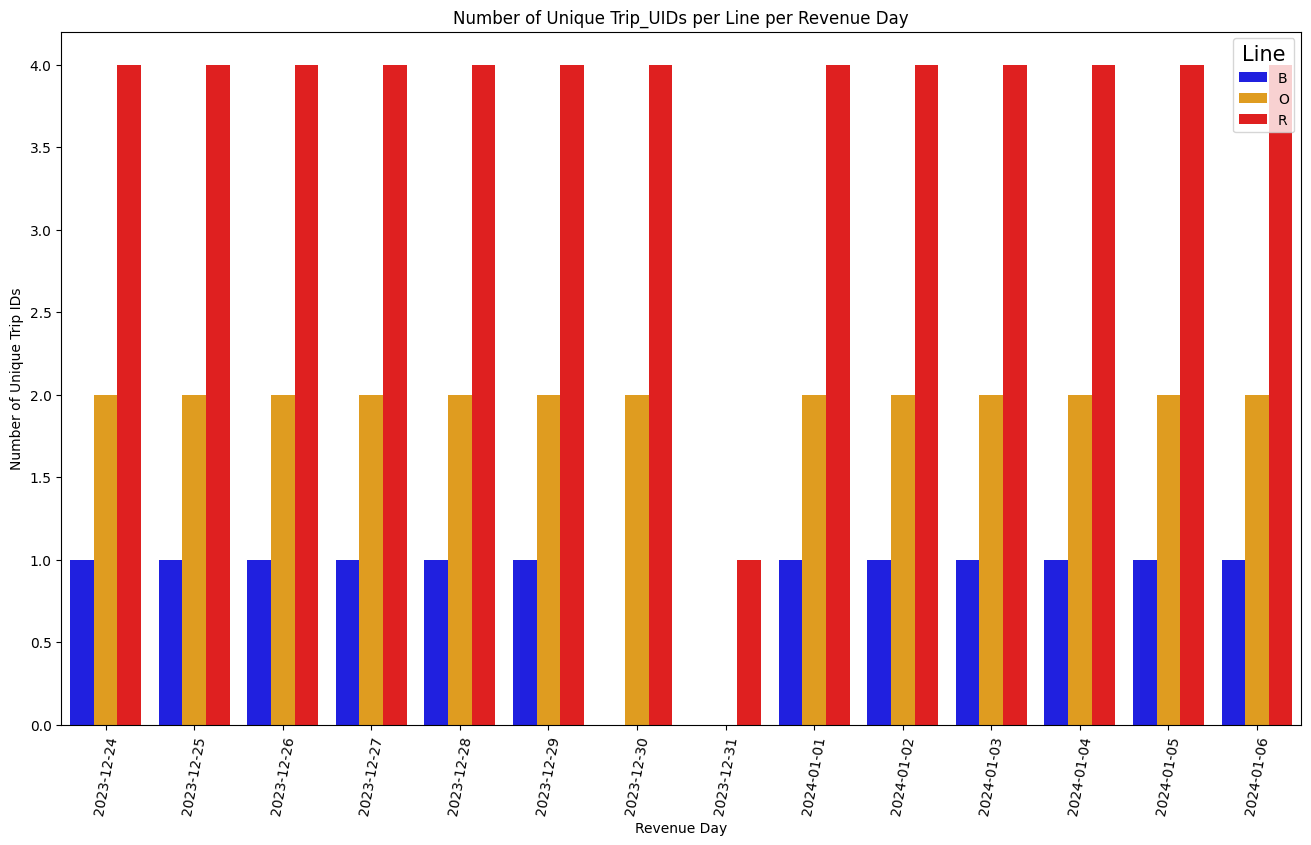

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

train_counts = result.groupby(['revenue_day', 'transit_line'])['trip_UID'].unique().reset_index()

unique_train_counts = result.groupby(['revenue_day', 'transit_line'])['trip_UID'].nunique().reset_index()

colors = ['blue', 'orange', 'red']

plt.figure(figsize=(16, 9))
sns.barplot(data = unique_train_counts, x='revenue_day', y='trip_UID', hue='transit_line', palette=colors)

plt.title('Number of Unique Trip_UIDs per Line per Revenue Day')
plt.xlabel('Revenue Day')
plt.ylabel('Number of Unique Trip IDs')
plt.legend(title='Line', title_fontsize='15')

plt.xticks(rotation=80)

plt.show()